In [200]:
import pandas as pd
import numpy as np
import functools
import seaborn as sns
import scipy
import collections
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

In [80]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
prices_day_0_df = pd.read_csv('../data/round-3-island-data-bottle/prices_round_3_day_0.csv', index_col='timestamp', sep=';')
prices_day_1_df = pd.read_csv('../data/round-3-island-data-bottle/prices_round_3_day_1.csv', index_col='timestamp', sep=';')
prices_day_2_df = pd.read_csv('../data/round-3-island-data-bottle/prices_round_3_day_2.csv', index_col='timestamp', sep=';')


In [3]:
Data_df = pd.concat([prices_day_0_df,prices_day_1_df,prices_day_2_df],axis = 0)

In [4]:
Data_df.head()

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
timestamp,,,,,,,,,,,,,,,,
0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0
0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0
0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0
0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0
100,0,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0


In [14]:
Data_df['product'].unique().tolist()

['CHOCOLATE', 'STRAWBERRIES', 'ROSES', 'GIFT_BASKET']

In [16]:
[x.lower() for x in Data_df['product'].unique().tolist()]

['chocolate', 'strawberries', 'roses', 'gift_basket']

In [17]:
Data_df.columns

Index(['day', 'product', 'bid_price_1', 'bid_volume_1', 'bid_price_2',
       'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1',
       'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3',
       'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')

In [38]:
df_chocolate_day_012 = Data_df.loc[Data_df['product']=='CHOCOLATE'].rename(columns={'mid_price': 'chocolate_mid_price'})[['day', 'chocolate_mid_price']]
df_strawberries_day_012 = Data_df.loc[Data_df['product']=='STRAWBERRIES'].rename(columns={'mid_price': 'strawberries_mid_price'})[['day', 'strawberries_mid_price']]
df_roses_day_012 = Data_df.loc[Data_df['product']=='ROSES'].rename(columns={'mid_price': 'roses_mid_price'})[['day', 'roses_mid_price']]
df_gift_basket_day_012 = Data_df.loc[Data_df['product']=='GIFT_BASKET'].rename(columns={'mid_price': 'gift_basket_mid_price'})[['day', 'gift_basket_mid_price']]

In [43]:
df_all_mid_prices_day_012 = functools.reduce(lambda left, right: pd.merge(left, right, on=['timestamp', 'day']), 
                                        [df_chocolate_day_012, df_strawberries_day_012, df_roses_day_012, df_gift_basket_day_012])

In [44]:
df_all_mid_prices_day_012.head()

,day,chocolate_mid_price,strawberries_mid_price,roses_mid_price,gift_basket_mid_price
timestamp,,,,,
0,0,8000.0,4000.0,15000.0,71355.0
100,0,8001.5,3999.5,15000.0,71349.5
200,0,8001.0,3999.5,15000.5,71347.0
300,0,8002.5,3999.5,15000.0,71350.5
400,0,8002.0,3999.5,14997.5,71341.5


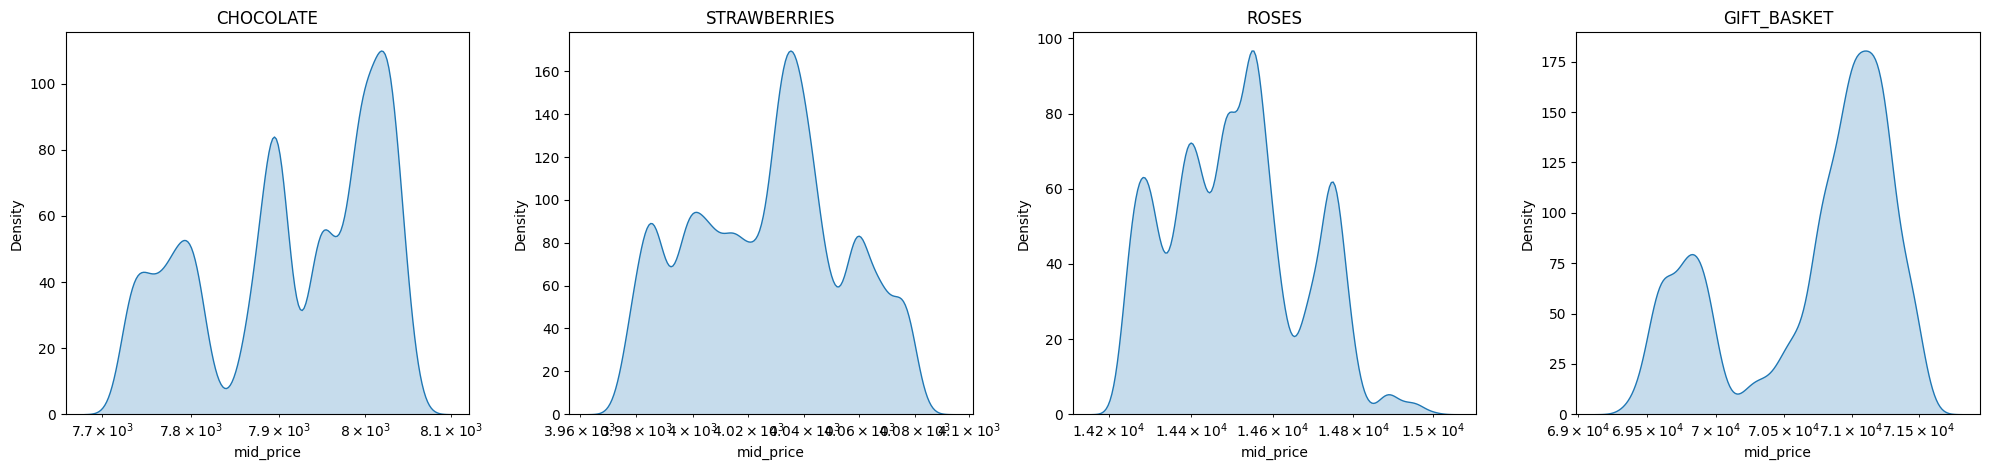

In [21]:
#kde of all features
features = Data_df['product'].unique().tolist()
n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
#fig.suptitle('Cumulative Distribution Functions for Each Feature')
axes = axes.ravel()
for i, feature in enumerate(features):
    sns.kdeplot(Data_df.loc[Data_df['product']==feature]['mid_price'], log_scale=True, fill=True, ax=axes[i])
    axes[i].set_title(f'{feature}')
    #axes[i].set_xlabel('Value')
    #axes[i].set_ylabel('Probability')
# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

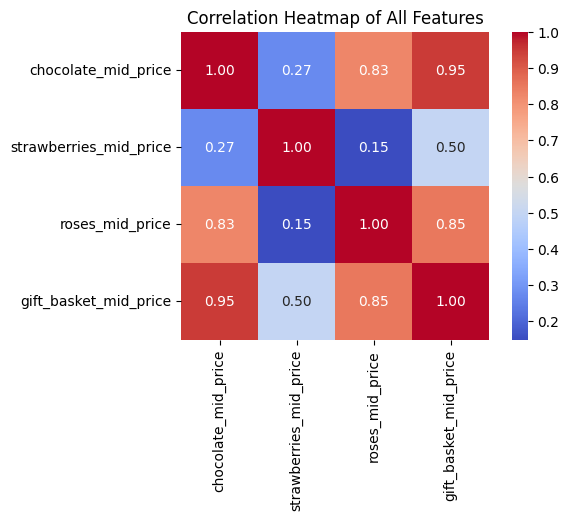

In [31]:
#Heat map
corr = df_all_mid_prices_day_012.corr()
# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap of All Features')
plt.show()


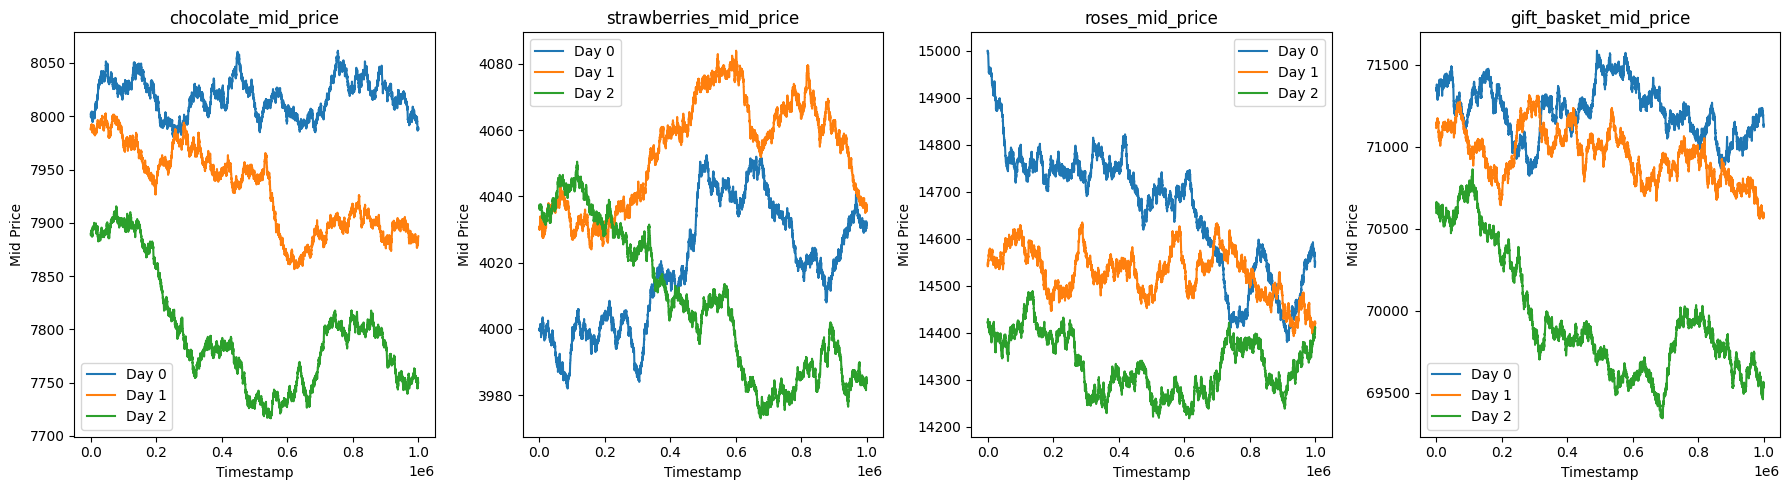

In [57]:
#Feature plots
features = ['chocolate_mid_price', 'strawberries_mid_price', 'roses_mid_price', 'gift_basket_mid_price']
n_features = len(features)
n_cols = 4  # Choose 1 column for a vertical layout
n_rows = n_features // n_cols + (n_features % n_cols > 0)
#n_rows = 1
# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))  # Adjust figure size as needed
# Flatten the axes array and iterate over it along with the features
#axes = axes.flatten() if n_rows > 1 else [axes]


for feature, ax in zip(features, axes.flatten()):
    for day in [0, 1, 2]:
        ax.plot(df_all_mid_prices_day_012[df_all_mid_prices_day_012.day == day].index,
                df_all_mid_prices_day_012[df_all_mid_prices_day_012.day == day][feature], label=f'Day {day}')
    ax.set_title(f'{feature}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Mid Price')
    ax.legend()

plt.tight_layout()
plt.show()

In [226]:
features

['chocolate_mid_price',
 'strawberries_mid_price',
 'roses_mid_price',
 'gift_basket_mid_price']

In [59]:
chocolate_prices_3days_arr = df_chocolate_day_012.chocolate_mid_price.values
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(chocolate_prices_3days_arr)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic - chocolate: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic - chocolate: -0.299432
p-value: 0.925585
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [60]:
strawberries_prices_3days_arr = df_strawberries_day_012.strawberries_mid_price.values
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(strawberries_prices_3days_arr)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic - strawberries: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic - strawberries: -0.934055
p-value: 0.776551
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [61]:
roses_prices_3days_arr = df_roses_day_012.roses_mid_price.values
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(roses_prices_3days_arr)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic - roses: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic - roses: -2.999098
p-value: 0.034979
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [62]:
gift_basket_prices_3days_arr = df_gift_basket_day_012.gift_basket_mid_price.values
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(gift_basket_prices_3days_arr)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic - gift_basket: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic - gift_basket: -0.590670
p-value: 0.873076
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### As shown above, only roses shows stationary at 3% level, may assume they are all non-stationary

In [76]:
features = ['chocolate_mid_price', 'strawberries_mid_price', 'roses_mid_price', 'gift_basket_mid_price']
for feature_ab in itertools.product(features, repeat=2):
    if feature_ab[0]!=feature_ab[1]:
        print(f'cointegration test on {feature_ab[0]}, {feature_ab[1]}\n')
        this_test = ts.coint(df_all_mid_prices_day_012[feature_ab[0]], df_all_mid_prices_day_012[feature_ab[1]])
        print(f'p_value: {this_test[1]}')
        print(this_test)
        

cointegration test on chocolate_mid_price, strawberries_mid_price

p_value: 0.9196434286521864
(-0.9036973785325402, 0.9196434286521864, array([-3.89680511, -3.33633368, -3.04459138]))
cointegration test on chocolate_mid_price, roses_mid_price

p_value: 0.09391665614636518
(-3.072709515039765, 0.09391665614636518, array([-3.89680511, -3.33633368, -3.04459138]))
cointegration test on chocolate_mid_price, gift_basket_mid_price

p_value: 0.07987947236904941
(-3.1435866460000397, 0.07987947236904941, array([-3.89680511, -3.33633368, -3.04459138]))
cointegration test on strawberries_mid_price, chocolate_mid_price

p_value: 0.8102670980122337
(-1.3619219296331688, 0.8102670980122337, array([-3.89680511, -3.33633368, -3.04459138]))
cointegration test on strawberries_mid_price, roses_mid_price

p_value: 0.8456364288800847
(-1.245299736573899, 0.8456364288800847, array([-3.89680511, -3.33633368, -3.04459138]))
cointegration test on strawberries_mid_price, gift_basket_mid_price

p_value: 0.61135

### strong co-integration relation exists especially on (roses_mid_price, chocolate_mid_price) as well as (roses_mid_price, gift_basket_mid_price)
### weak co-integration relation exists on (chocolate_mid_price, roses_mid_price), (chocolate_mid_price, gift_basket_mid_price) (roses_mid_price, strawberries_mid_price) (gift_basket_mid_price, chocolate_mid_price)

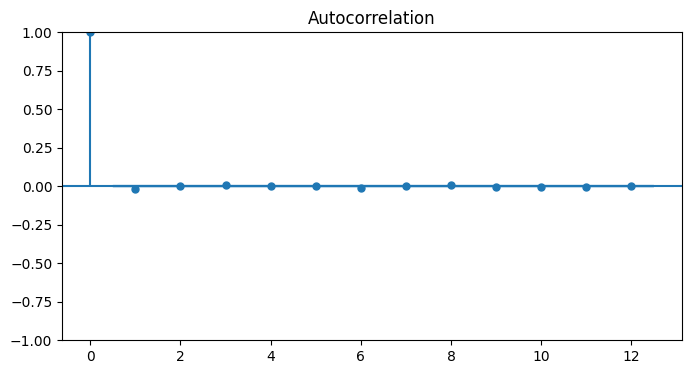

In [91]:
#features = ['chocolate_mid_price', 'strawberries_mid_price', 'roses_mid_price', 'gift_basket_mid_price']

# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (8,4)

# plots the ACF for train period with 50 lags
plot = plot_acf(df_all_mid_prices_day_012['chocolate_mid_price'].diff().dropna(), lags = 12)

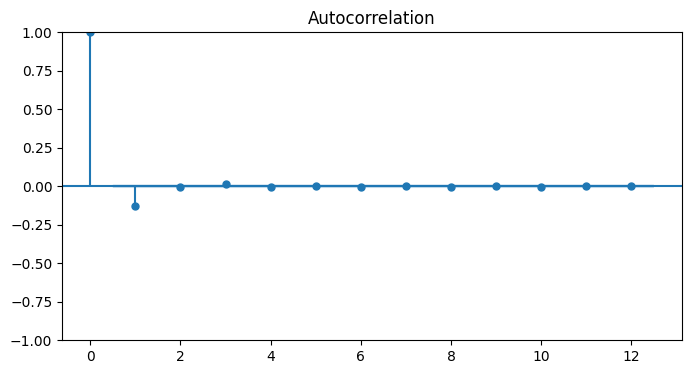

In [92]:
#features = ['chocolate_mid_price', 'strawberries_mid_price', 'roses_mid_price', 'gift_basket_mid_price']

# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (8,4)

# plots the ACF for train period with 50 lags
plot = plot_acf(df_all_mid_prices_day_012['strawberries_mid_price'].diff().dropna(), lags = 12)

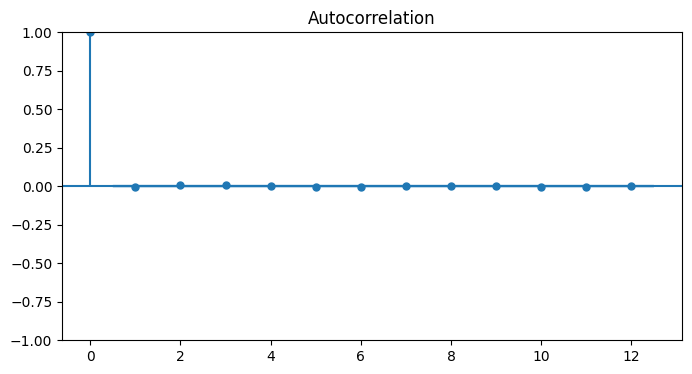

In [93]:
#features = ['chocolate_mid_price', 'strawberries_mid_price', 'roses_mid_price', 'gift_basket_mid_price']

# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (8,4)

# plots the ACF for train period with 50 lags
plot = plot_acf(df_all_mid_prices_day_012['roses_mid_price'].diff().dropna(), lags = 12)

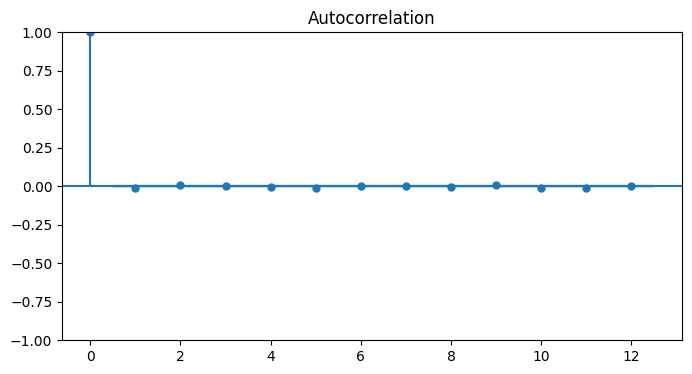

In [94]:
#features = ['chocolate_mid_price', 'strawberries_mid_price', 'roses_mid_price', 'gift_basket_mid_price']

# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (8,4)

# plots the ACF for train period with 50 lags
plot = plot_acf(df_all_mid_prices_day_012['gift_basket_mid_price'].diff().dropna(), lags = 12)

### as acf plots shown above, every series is stationary on lag 1, except for strawberries_mid_price which is stationary on lag 2

### try regression and build a Error Correction Model (ECM) accordingly
### use day 0, 1 to train and day 2 to test

In [97]:
df_all_mid_prices_day_012['chocolate_mid_price'].head()

timestamp
0      8000.0
100    8001.5
200    8001.0
300    8002.5
400    8002.0
Name: chocolate_mid_price, dtype: float64

### we may do de-mean on features and target to make the condition number lower, but need to keep a running mean in live data, skip for now

In [113]:
new_index = "timestamp_" + df_all_mid_prices_day_012.index.astype(str) + "_day_" + df_all_mid_prices_day_012['day'].astype(str)

In [115]:
df_all_mid_prices_day_012.index = new_index

In [120]:
#features = ['chocolate_mid_price', 'strawberries_mid_price', 'roses_mid_price', 'gift_basket_mid_price']
#df_all_mid_prices_day_012['gift_basket_mid_price']

# adds a constant term
X_train_chocolate_gift = df_all_mid_prices_day_012[(df_all_mid_prices_day_012.day==0) 
                                             | (df_all_mid_prices_day_012.day==1)][['chocolate_mid_price', 'gift_basket_mid_price']]
X_train_chocolate_gift = sm.add_constant(X_train_chocolate_gift)
X_test_chocolate_gift = df_all_mid_prices_day_012[df_all_mid_prices_day_012.day==2][['chocolate_mid_price', 'gift_basket_mid_price']]

y_train_roses = df_all_mid_prices_day_012[(df_all_mid_prices_day_012.day==0) 
                                             | (df_all_mid_prices_day_012.day==1)]['roses_mid_price']
y_test_roses = df_all_mid_prices_day_012[df_all_mid_prices_day_012.day==2]['roses_mid_price']
# estimates a linear regression of roses_mid_price ~ const + chocolate_mid_price
lr_model_rcg = sm.OLS(y_train_roses, X_train_chocolate_gift)
lr_model_rcg_fit = lr_model_rcg.fit(cov_type='HC0')

# prints a summary
print(lr_model_rcg_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        roses_mid_price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                 1.040e+04
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:00:38   Log-Likelihood:            -1.1881e+05
No. Observations:               20000   AIC:                         2.376e+05
Df Residuals:                   19997   BIC:                         2.376e+05
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.147e+

In [121]:
# ADF test on the residuals, which has to be stationary 
# “c” : constant only (default).
# “ct” : constant and trend.
# “ctt” : constant, and linear and quadratic trend.
# “n” : no constant, no trend.

for i in ['c', 'ct', 'ctt', 'n']:
    result = adfuller(lr_model_rcg_fit.resid, regression = i)
    print('ADF Statistic with %s for Closing X_train_chocolate price: %f' % (i, result[0]))
    print('p-value: %f\n' % result[1])

ADF Statistic with c for Closing X_train_chocolate price: -3.598371
p-value: 0.005792

ADF Statistic with ct for Closing X_train_chocolate price: -3.383225
p-value: 0.053670

ADF Statistic with ctt for Closing X_train_chocolate price: -3.666993
p-value: 0.076322

ADF Statistic with n for Closing X_train_chocolate price: -3.598336
p-value: 0.000338



### as shown above, constant only & no constant, no trend shows significant p-value for stationary test

### The error-correction term in the ECM must be negative. The lagged residuals from the linear regression represent the deviation from the long-run relationship in the previous period. 

#### The intuition is if our stock price is above its long-run equilibrium with the market, the negative coefficient pulls it back down. If it is below the long-run equilibrium, the negatives will cancel out and become positive pulling the stock price back up. That is the magic of the ECM.

In [143]:
df_all_mid_prices_day_012['disequilibrium'] = lr_model_rcg_fit.resid
df_all_mid_prices_day_012.disequilibrium = df_all_mid_prices_day_012.disequilibrium.shift(1)

In [269]:
diff_train_chocolate_gift = X_train_chocolate_gift.copy()
diff_train_chocolate_gift = diff_train_chocolate_gift.join(y_train_roses)
diff_train_chocolate_gift['roses_mid_price'] = diff_train_chocolate_gift['roses_mid_price'].diff()
diff_train_chocolate_gift['chocolate_mid_price'] = diff_train_chocolate_gift['chocolate_mid_price'].diff()
diff_train_chocolate_gift['gift_basket_mid_price'] = diff_train_chocolate_gift['gift_basket_mid_price'].diff()
diff_train_chocolate_gift = diff_train_chocolate_gift.join(df_all_mid_prices_day_012['disequilibrium'])

diff_train_chocolate_gift = diff_train_chocolate_gift.dropna()

In [270]:
diff_train_chocolate_gift.head()

,const,chocolate_mid_price,gift_basket_mid_price,roses_mid_price,disequilibrium
timestamp_100_day_0,1.0,1.5,-5.5,0.0,307.426107
timestamp_200_day_0,1.0,-0.5,-2.5,0.5,309.357958
timestamp_300_day_0,1.0,1.5,3.5,-0.5,310.783182
timestamp_400_day_0,1.0,-0.5,-9.0,-2.5,308.955978
timestamp_500_day_0,1.0,-0.5,2.0,-1.0,309.734964


In [247]:
diff_test_chocolate_gift = X_test_chocolate_gift.copy()
diff_test_chocolate_gift = diff_test_chocolate_gift.join(y_test_roses)
diff_test_chocolate_gift['roses_mid_price'] = diff_test_chocolate_gift['roses_mid_price'].diff()
diff_test_chocolate_gift['chocolate_mid_price'] = diff_test_chocolate_gift['chocolate_mid_price'].diff()
diff_test_chocolate_gift['gift_basket_mid_price'] = diff_test_chocolate_gift['gift_basket_mid_price'].diff()
diff_test_chocolate_gift = sm.add_constant(diff_test_chocolate_gift)

In [248]:
diff_test_chocolate_gift.head()

,const,chocolate_mid_price,gift_basket_mid_price,roses_mid_price
timestamp_0_day_2,1.0,NaN,NaN,NaN
timestamp_100_day_2,1.0,0.5,20.0,2.5
timestamp_200_day_2,1.0,1.0,-1.5,-1.5
timestamp_300_day_2,1.0,-0.5,-1.5,-1.0
timestamp_400_day_2,1.0,0.0,14.0,0.5


In [152]:
predictors = ['chocolate_mid_price', 'gift_basket_mid_price'
             , 'disequilibrium', 'const']
ecm_train = sm.OLS(diff_train_chocolate_gift['roses_mid_price'], diff_train_chocolate_gift[predictors])
ecm_train_fit = ecm_train.fit(cov_type='HC0')

# prints a summary
print(ecm_train_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        roses_mid_price   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     1177.
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:10:08   Log-Likelihood:                -46997.
No. Observations:               19999   AIC:                         9.400e+04
Df Residuals:                   19995   BIC:                         9.403e+04
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
chocolate_mid_price      -0.56

In [276]:
# defines a function to perform rolling forecasts with a ECM and intakes a y_var as a string
# X_vars as a list, lr_X_vars as a list, and the rest of the inputs are dataframes, with lr_
# indicating level variables used to estimate the long-run relationship, and diff_ representing
# differenced data
def roll_forecast_ecm(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test):
    
    # creates two new dataframes that will be added to as the forecast rolls 
    history = lr_train
    diff_history = diff_train
    
    # estimates a linear model to predict the longrun relationship
    lr_model_train = sm.OLS(history[[y_var]], history[lr_X_vars])
    # fits the lr model
    lr_model_train_fit = lr_model_train.fit(cov_type='HC0')
    # adds a disequilibrium column for the training period
    diff_train['disequilibrium'] = lr_model_train_fit.resid.shift(1)
    
    
    # this chunk of data does one-step ahead predictions of the disequilibrium    
    
    # creates an empty list that will hold the residuals for the next period
    disequilibrium = []
    
    # loops through the indexes of the set being forecasted
    for i in tqdm(range(len(lr_test))):
        
        # estimates a linear model to predict the longrun relationship
        # .replace([np.inf, -np.inf], np.nan).fillna(0)
        lr_model = sm.OLS(history[[y_var]]
                          , history[lr_X_vars])
        # fits the lr model
        lr_model_fit = lr_model.fit(cov_type='HC0')
        # forecasts the disequilibrium in the next period and appends it to the list by predicting 
        # the closing price using the 1st lagged value of the independent variable at t+1, which makes it
        # at time t, and subtracting the closing price at time t, giving the residual for time t, which is 
        # t - 1 for the future value we want to predict
        disequilibrium_hat = (float(lr_model_fit.predict(history[-1:][lr_X_vars]))
                             - float(history[-1:][y_var].values))
        disequilibrium.append(disequilibrium_hat)
        # grabs the observation at the ith index
        obs = lr_test[i : i + 1]
        #print(f'obs: {obs}')
        #print(f'history.tail(): {history.tail()}')
        
        # appends the observation to the estimation data set
        #history = history.append(obs)
        #return history, obs
        history = pd.concat([history, obs])
        
    # creates a column of the lagged disequilibrium values
    diff_test['disequilibrium'] = disequilibrium
    
    
    # this chunk of code does the 1-step ahead ECM estimation and prediction
    
    predictions = []
    
    # this list will store the error_correction coefficients  
    error_correction_coefficients = []
    # this list stores the standard error of the EC coefficients
    error_correction_coef_stderr = []

        
    # loops through the indexes of the set being forecasted
    for i in tqdm(range(len(diff_test))):
        
        # estimates an ECM to predict future values
        ecm_model = sm.OLS(diff_history[[y_var]].fillna(0)
                           , diff_history[X_vars].fillna(0))
        # fits the ECM
        ecm_model_fit = ecm_model.fit(cov_type='HC0')
        # predicts the future closing price change and appends it to the list of predictions
        delta_y_hat = float(ecm_model_fit.predict(diff_test[i : i + 1][X_vars]))
        predictions.append(delta_y_hat)
        # grabs the observation at the ith index
        obs = diff_test[i : i + 1]
        # appends the observation to the estimation data set
        #diff_history = diff_history.append(obs)
        diff_history = pd.concat([diff_history, obs])
        
        # appends the error_correction coefficient to the list  
        error_correction_coefficients.append(ecm_model_fit.params.disequilibrium)
        error_correction_coef_stderr.append(ecm_model_fit.HC0_se.disequilibrium)
    
    # adds columns for our lists
    diff_test['delta_y_hat'] = predictions     
    diff_test['ec_coef'] = error_correction_coefficients
    diff_test['ec_stderr'] = error_correction_coef_stderr
    
    # returns predictions
    return (diff_test, ecm_model_fit, disequilibrium)  

### below are for debug only

In [153]:
predictors

['chocolate_mid_price', 'gift_basket_mid_price', 'disequilibrium', 'const']

In [272]:
diff_train_chocolate_gift[predictors]

,chocolate_mid_price,gift_basket_mid_price,disequilibrium,const
timestamp_100_day_0,1.5,-5.5,307.426107,1.0
timestamp_200_day_0,-0.5,-2.5,309.357958,1.0
timestamp_300_day_0,1.5,3.5,310.783182,1.0
timestamp_400_day_0,-0.5,-9.0,308.955978,1.0
timestamp_500_day_0,-0.5,2.0,309.734964,1.0
...,...,...,...,...
timestamp_999500_day_1,0.0,0.0,11.290692,1.0
timestamp_999600_day_1,2.5,10.0,10.290692,1.0
timestamp_999700_day_1,0.0,-14.0,3.569864,1.0
timestamp_999800_day_1,2.0,-1.0,12.139504,1.0


In [271]:
diff_test_chocolate_gift

,const,chocolate_mid_price,gift_basket_mid_price,roses_mid_price
timestamp_0_day_2,1.0,NaN,NaN,NaN
timestamp_100_day_2,1.0,0.5,20.0,2.5
timestamp_200_day_2,1.0,1.0,-1.5,-1.5
timestamp_300_day_2,1.0,-0.5,-1.5,-1.0
timestamp_400_day_2,1.0,0.0,14.0,0.5
...,...,...,...,...
timestamp_999500_day_2,1.0,-2.0,-14.0,4.0
timestamp_999600_day_2,1.0,0.0,-5.0,-1.5
timestamp_999700_day_2,1.0,0.0,13.5,3.5
timestamp_999800_day_2,1.0,-0.5,-1.0,1.0


In [312]:
diff_test[1 : 1 + 1][X_vars]

,chocolate_mid_price,gift_basket_mid_price,disequilibrium,const
timestamp_100_day_2,0.5,20.0,60.567166,1.0


In [275]:
sm.OLS(diff_train_chocolate_gift.fillna(0)[['roses_mid_price']], diff_train_chocolate_gift.fillna(0)[predictors])

In [302]:
# creates two new dataframes that will be added to as the forecast rolls 
history = lr_train
diff_history = diff_train

# estimates a linear model to predict the longrun relationship
lr_model_train = sm.OLS(history[[y_var]], history[lr_X_vars])
# fits the lr model
lr_model_train_fit = lr_model_train.fit(cov_type='HC0')
# adds a disequilibrium column for the training period
diff_train['disequilibrium'] = lr_model_train_fit.resid.shift(1)


# this chunk of data does one-step ahead predictions of the disequilibrium    

# creates an empty list that will hold the residuals for the next period
disequilibrium = []

In [303]:
# loops through the indexes of the set being forecasted
for i in tqdm(range(len(lr_test.iloc[:2]))):
    
    # estimates a linear model to predict the longrun relationship
    # .replace([np.inf, -np.inf], np.nan).fillna(0)
    lr_model = sm.OLS(history[[y_var]]
                        , history[lr_X_vars])
    # fits the lr model
    lr_model_fit = lr_model.fit(cov_type='HC0')
    # forecasts the disequilibrium in the next period and appends it to the list by predicting 
    # the closing price using the 1st lagged value of the independent variable at t+1, which makes it
    # at time t, and subtracting the closing price at time t, giving the residual for time t, which is 
    # t - 1 for the future value we want to predict
    disequilibrium_hat = (float(lr_model_fit.predict(history[-1:][lr_X_vars]))
                            - float(history[-1:][y_var].values))
    disequilibrium.append(disequilibrium_hat)
    # grabs the observation at the ith index
    obs = lr_test[i : i + 1]
    #print(f'obs: {obs}')
    #print(f'history.tail(): {history.tail()}')
    
    # appends the observation to the estimation data set
    #history = history.append(obs)
    #return history, obs
    history = pd.concat([history, obs])

100%|██████████| 2/2 [00:00<00:00, 184.23it/s]


In [304]:
obs

,chocolate_mid_price,gift_basket_mid_price,roses_mid_price
timestamp_100_day_2,7889.5,70618.5,14424.0


In [305]:
disequilibrium

[57.04749828437161, 60.567165597323765]

In [301]:
(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test) = ('roses_mid_price', 
                                                                        predictors, 
                                                                        ['chocolate_mid_price', 'gift_basket_mid_price'], 
                                                                        X_train_chocolate_gift.join(y_train_roses), 
                                                                        X_test_chocolate_gift.join(y_test_roses), 
                                                                        diff_train_chocolate_gift.fillna(0), 
                                                                        diff_test_chocolate_gift.fillna(0)) 

In [306]:
     

ecm_results = roll_forecast_ecm(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test)
#history, obs = roll_forecast_ecm(y_var, X_vars, lr_X_vars, lr_train, lr_test, diff_train, diff_test)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:43<00:00, 227.28it/s]


In [239]:
X_train_chocolate_gift.join(y_train_roses)[-1:][['chocolate_mid_price', 'gift_basket_mid_price']]

,chocolate_mid_price,gift_basket_mid_price
timestamp_999900_day_1,7887.5,70586.5


In [240]:
float(X_train_chocolate_gift.join(y_train_roses)[-1:]['roses_mid_price'].values)

14422.5

In [242]:
diff_test_chocolate_gift.fillna(0)[1 : 1 + 1][predictors]

,chocolate_mid_price,gift_basket_mid_price,disequilibrium,const
timestamp_100_day_2,0.5,20.0,0.0,1.0


In [307]:
print('Mean Absolute Error over Test Data Set: ' + 
      str(sum(abs(ecm_results[0][y_var] - ecm_results[0].delta_y_hat)) / len(ecm_results[0])))
print('')


Mean Absolute Error over Test Data Set: 1.9873073626516464



<Axes: xlabel='roses_mid_price', ylabel='Density'>

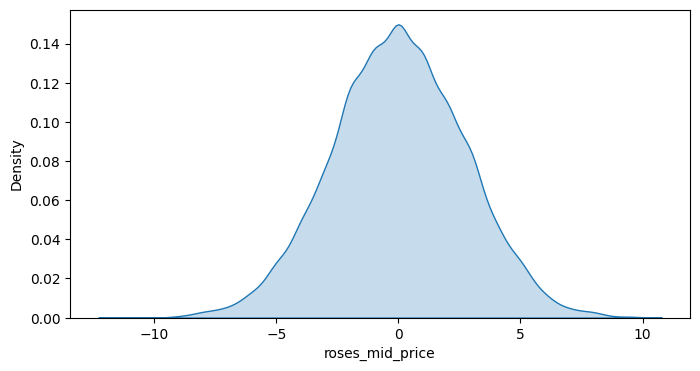

In [320]:
sns.kdeplot(ecm_results[0].roses_mid_price, fill=True)

In [308]:
ecm_results[0]

,const,chocolate_mid_price,gift_basket_mid_price,roses_mid_price,disequilibrium,delta_y_hat,ec_coef,ec_stderr
timestamp_0_day_2,1.0,0.0,0.0,0.0,57.047498,-0.061040,-0.000608,0.000182
timestamp_100_day_2,1.0,0.5,20.0,2.5,60.567166,2.665782,-0.000608,0.000182
timestamp_200_day_2,1.0,1.0,-1.5,-1.5,61.478441,-0.857392,-0.000608,0.000182
timestamp_300_day_2,1.0,-0.5,-1.5,-1.0,63.127563,-0.006885,-0.000609,0.000182
timestamp_400_day_2,1.0,0.0,14.0,0.5,63.683142,2.043765,-0.000609,0.000182
...,...,...,...,...,...,...,...,...
timestamp_999500_day_2,1.0,-2.0,-14.0,4.0,-150.123964,-0.930361,-0.000444,0.000171
timestamp_999600_day_2,1.0,0.0,-5.0,-1.5,-157.164669,-0.695946,-0.000448,0.000171
timestamp_999700_day_2,1.0,0.0,13.5,3.5,-156.453468,2.082547,-0.000447,0.000171
timestamp_999800_day_2,1.0,-0.5,-1.0,1.0,-157.792380,0.185799,-0.000448,0.000171


In [310]:
print(ecm_results[1].summary())

                            OLS Regression Results                            
Dep. Variable:        roses_mid_price   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     1768.
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        23:31:53   Log-Likelihood:                -70348.
No. Observations:               29998   AIC:                         1.407e+05
Df Residuals:                   29994   BIC:                         1.407e+05
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
chocolate_mid_price      -0.56